# setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%%capture
!pip install git+https://github.com/EleutherAI/sae.git

In [ ]:
# you should load this before cloning repo files
# from .config import SaeConfig
# from .utils import decoder_impl

from sae.config import SaeConfig
from sae.utils import decoder_impl
from sae import Sae

Triton not installed, using eager implementation of SAE decoder.


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
from fnmatch import fnmatch
from pathlib import Path
from typing import NamedTuple, Optional, Callable, Union, List, Tuple
# from jaxtyping import Float, Int

import einops
import torch
from torch import Tensor, nn
from huggingface_hub import snapshot_download
from natsort import natsorted
from safetensors.torch import load_model, save_model

device = "cuda" if torch.cuda.is_available() else "cpu"

## corr fns

In [ ]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        end = min(start + batch_size, normalized_B.shape[1])
        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        # max_indices.append(max_idx + start)  # Adjust indices for the batch offset
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    return torch.cat(max_indices), torch.cat(max_values)

## sim fns

In [ ]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [ ]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [ ]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [ ]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [ ]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [ ]:
def score_rand(num_feats, sim_fn, shapereq_bool=False):
    all_rand_scores = []
    for i in range(1):
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

        if shapereq_bool:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
        else:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
        all_rand_scores.append(score)
    # print(sum(all_rand_scores) / len(all_rand_scores))
    # plt.hist(all_rand_scores)
    # plt.show()
    return sum(all_rand_scores) / len(all_rand_scores)

In [ ]:
# import random
# row_idxs = list(range(weight_matrix_2.shape[0]))
# random.shuffle(row_idxs)
# jaccard_similarity(weight_matrix_np, weight_matrix_2[row_idxs])

## plot fns

In [ ]:
def plot_svcca_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['svcca_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_meanCorr_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr'] for i in range(0, 12)]
    # unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    # rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    # label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
# def plot_js_byLayer(layer_to_dictscores):
#     for key, sub_dict in layer_to_dictscores.items():
#         for sub_key, value in sub_dict.items():
#             sub_dict[sub_key] = round(value, 4)

#     layers = [f'L{i}' for i in range(0, 12)]
#     paired_values = [layer_to_dictscores[i]['1-1 jaccard_paired'] for i in range(0, 12)]
#     unpaired_values = [layer_to_dictscores[i]['1-1 jaccard_unpaired'] for i in range(0, 12)]

#     # Plotting configuration
#     x = np.arange(len(layers))  # label locations
#     width = 0.35  # width of the bars

#     # Increase figure size
#     fig, ax = plt.subplots(figsize=(12, 7))  # Slightly increased figure size
#     rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
#     rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

#     # Adding labels, title and custom x-axis tick labels
#     ax.set_ylabel('Jaccard NN')
#     ax.set_title('SAEs comparison by Pythia 70m MLP0 vs 160m MLP Layers')
#     ax.set_xticks(x)
#     ax.set_xticklabels(layers)
#     ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
#     ax.legend()

#     # Label bars with increased font size and different positioning for paired and unpaired
#     def label_bars(rects, is_paired):
#         for rect in rects:
#             height = rect.get_height()
#             label_height = height + 0.05 if is_paired else height + 0.01
#             ax.text(rect.get_x() + rect.get_width()/2., label_height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)  # Increased font size to 12

#     label_bars(rects1, True)   # Paired bars
#     label_bars(rects2, False)  # Unpaired bars

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     # Increase y-axis limit to accommodate higher labels
#     ax.set_ylim(0, 1.1)  # Increased from 1 to 1.1

#     plt.show()

# load data

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from datasets import load_dataset
# dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True)

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
batch_size = 100
maxseqlen = 300

def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter, batch_size)

# Tokenize the batch
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

# load models

In [ ]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
model_2 = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m")

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

# case A, MLP2 vs

## load SAE model A

In [ ]:
layer_id = 2
hookpoint = "layers." + str(layer_id)
name = "EleutherAI/sae-pythia-70m-32k"
decoder=True

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 512}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_np = sae.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model(**inputs, output_hidden_states=True)
    reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## L2 v L2: analyze corr

 MLP2 vs MLP2

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

# for i in range(1, 3): # 0, 12
i=2
dictscores = {}

hookpoint = "layers." + str(i)

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae_2,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model_2(**inputs, output_hidden_states=True)
    reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
"""
`batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
"""
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.23333740234375


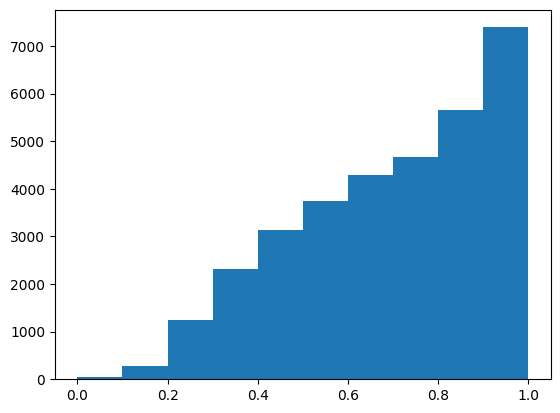

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  2604 | Count:  1867 | Corr:  0.9148081
FeatID:  11415 | Count:  1272 | Corr:  0.39981055
FeatID:  16337 | Count:  885 | Corr:  0.798584
FeatID:  32697 | Count:  617 | Corr:  0.18044904
FeatID:  21787 | Count:  331 | Corr:  0.7753681
FeatID:  32352 | Count:  325 | Corr:  0.84321123
FeatID:  12813 | Count:  260 | Corr:  0.9459207
FeatID:  18972 | Count:  254 | Corr:  0.47722584
FeatID:  12313 | Count:  250 | Corr:  0.94422275
FeatID:  18186 | Count:  246 | Corr:  0.9498456
FeatID:  32565 | Count:  221 | Corr:  0.3425599
FeatID:  24468 | Count:  216 | Corr:  0.25493762
FeatID:  1182 | Count:  167 | Corr:  0.7401721
FeatID:  3128 | Count:  165 | Corr:  0.37767866
FeatID:  15282 | Count:  141 | Corr:  0.73332477
FeatID:  17626 | Count:  110 | Corr:  0.61508304
FeatID:  10852 | Count:  107 | Corr:  0.74052733
FeatID:  22809 | Count:  95 | Corr:  0.7157822
FeatID:  10593 | Count:  89 | Corr:  0.7055516
FeatID:  21744 | Count:  81 | Corr:  0.82881176


In [ ]:
# num_featB_to_rmv
sum([item[1] for item in sorted_feat_counts[:17]])

7434

In [ ]:
max_element = len(highest_correlations_indices_AB)
counts = Counter(highest_correlations_indices_AB)

# Initialize bins
bin_0 = 0
bin_1 = 0
bin_2_to_10 = 0
bin_11_to_100 = 0
bin_101_to_1000 = 0
bin_over_1000 = 0

# Calculate bins
for i in range(max_element + 1):
    count = counts.get(i, 0)
    if count == 0:
        bin_0 += 1
    elif count == 1:
        bin_1 += 1
    elif 2 <= count <= 10:
        bin_2_to_10 += 1
    elif 11 <= count <= 100:
        bin_11_to_100 += 1
    elif 101 <= count <= 1000:
        bin_101_to_1000 += 1
    elif count > 1000:
        bin_over_1000 += 1

# Display bin counts
print(f"Count of elements appearing 0 times: {bin_0}")
print(f"Count of elements appearing exactly 1 time: {bin_1}")
print(f"Count of elements appearing between 2 and 10 times: {bin_2_to_10}")
print(f"Count of elements appearing between 11 and 100 times: {bin_11_to_100}")
print(f"Count of elements appearing between 101 and 1000 times: {bin_101_to_1000}")
print(f"Count of elements appearing over 1000 times: {bin_over_1000}")

Count of elements appearing 0 times: 25123
Count of elements appearing exactly 1 time: 2663
Count of elements appearing between 2 and 10 times: 4698
Count of elements appearing between 11 and 100 times: 268
Count of elements appearing between 101 and 1000 times: 15
Count of elements appearing over 1000 times: 2


In [ ]:
# Filter out elements with counts over 100
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

In [ ]:
unkept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count > 100]
len(unkept_modA_feats)

17

In [ ]:
for i in range(10):
    print(sorted_feat_counts[i][0] in kept_modA_feats)

False
False
False
False
False
False
False
False
False
False


In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)

In [ ]:
len(filt_corr_ind_B)

25351

In [ ]:
len(filt_corr_ind_A)

25351

In [ ]:
len(highest_correlations_indices_AB)

32768

In [ ]:
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

% unique:  0.3016054593507159


In [ ]:
len(highest_correlations_values_AB[filt_corr_ind_B])

28124

In [ ]:
new_corrs = []
for fInd in filt_corr_ind_B:
    new_corrs.append(highest_correlations_values_AB[fInd])

In [ ]:
sum(new_corrs) / len(new_corrs)

0.6943414370229862

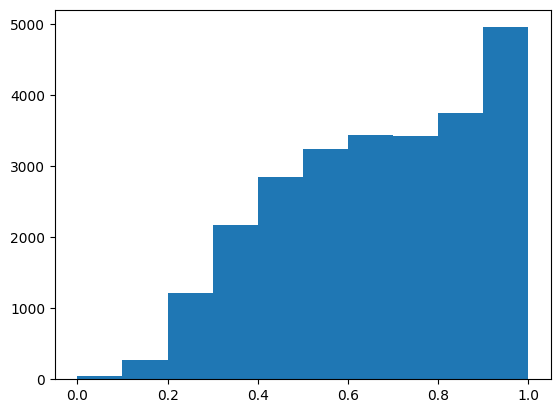

In [ ]:
plt.hist(new_corrs)
plt.show()

### run sim metric

In [ ]:
###########
# sim tests

dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")

num_feats = len(filt_corr_ind_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

0.003834852983136252
Layer: 9
mean_actv_corr: 0.6951166202568402
svcca_paired: 0.33615045216432426
svcca_unpaired: 0.003834852983136252




## rmv all corr less than 0.1

In [ ]:
new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

In [ ]:
len(new_highest_correlations_indices_A)

25300

In [ ]:
len(list(set(new_highest_correlations_indices_A)))

7644

In [ ]:
len(list(set(new_highest_correlations_indices_B)))

25300

In [ ]:
paired_svcca = svcca(weight_matrix_np[(new_highest_correlations_indices_A)], weight_matrix_2[new_highest_correlations_indices_B, :], "nd")
paired_svcca

0.3363421353665245

## rmv all 0 corr

In [ ]:
new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

In [ ]:
len(new_highest_correlations_indices_A)

25301

In [ ]:
len(list(set(new_highest_correlations_indices_A)))

7645

In [ ]:
len(list(set(new_highest_correlations_indices_B)))

25301

In [ ]:
paired_svcca = svcca(weight_matrix_np[(new_highest_correlations_indices_A)], weight_matrix_2[new_highest_correlations_indices_B, :], "nd")
paired_svcca

0.3363423008189529

## run sim metric - filt counts over 10

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 10]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  0.37559561821486465
num feats after filt:  20357


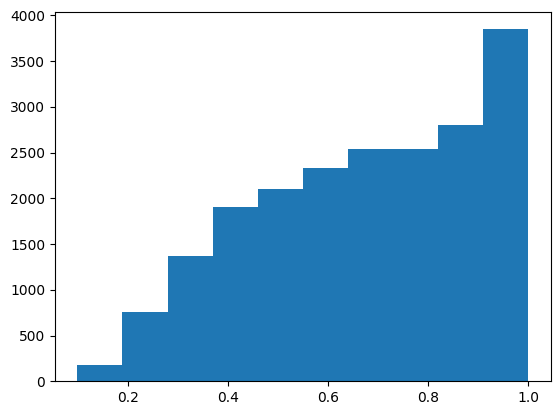

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr_filt: 0.6734634566020566
svcca_paired: 0.3519547511778723
svcca_unpaired: 0.00397701202904952




In [ ]:
new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

% unique after filt:  0.37561406956179993
num feats after filt:  20356
mean_actv_corr_filt: 0.6734916672980207
svcca_paired: 0.35195715124221233
svcca_unpaired: 0.011307675161812403




## run sim metric - filt counts over 1

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 1]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  1.0001308044473511
num feats after filt:  7645


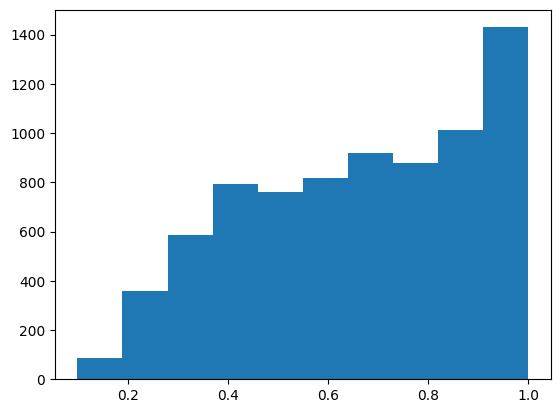

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr_filt: 0.6601237599379179
svcca_paired: 0.4101621152197052
svcca_unpaired: 0.010148162062426696




In [ ]:
new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

% unique after filt:  1.000261643118786
num feats after filt:  7644
mean_actv_corr_filt: 0.6601971400046867
svcca_paired: 0.41016734429264584
svcca_unpaired: 0.023289230913498653




## loop- filter counts over 100 and rmv corr of 0

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

for i in range(0, 12): # 0, 12
    dictscores = {}

    hookpoint = "layers." + str(i)

    repo_path = Path(
                snapshot_download(
                    name,
                    allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                    # allow_patterns = None
                )
            )
    if hookpoint is not None:
        repo_path = repo_path / hookpoint
    path = Path(repo_path)
    cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
    d_in = cfg_dict.pop("d_in")
    cfg = SaeConfig(**cfg_dict)

    sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

    load_model(
        model=sae_2,
        filename=str(path / "sae.safetensors"),
        device=str(device),
        strict=decoder,
    )

    weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        outputs = model_2(**inputs, output_hidden_states=True)
        reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
    reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

    """
    `batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
    """
    highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
    highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
    highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

    num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
    print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

    # dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

    ###########
    # filter

    sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
    kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

    filt_corr_ind_A = []
    filt_corr_ind_B = []
    seen = set()
    for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
        if ind_A in kept_modA_feats:
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
        elif ind_A not in seen:  # only keep one if it's over count X
            seen.add(ind_A)
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
    # num_unq_pairs = len(list(set(filt_corr_ind_A)))
    # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

    new_highest_correlations_indices_A = []
    new_highest_correlations_indices_B = []
    new_highest_correlations_values = []

    for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
        val = highest_correlations_values_AB[ind_B]
        if val > 0:
            new_highest_correlations_indices_A.append(ind_A)
            new_highest_correlations_indices_B.append(ind_B)
            new_highest_correlations_values.append(val)

    print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
    print("num feats after filt: ", len(new_highest_correlations_indices_A))

    dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

    ###########
    # sim tests

    # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
    dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

    # num_feats = len(filt_corr_ind_A)
    num_feats = len(new_highest_correlations_indices_A)
    dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

    print("Layer: " + str(i))
    for key, value in dictscores.items():
        print(key + ": " + str(value))
    print("\n")

    layer_to_dictscores[i] = dictscores

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.193084716796875
% unique after filt:  0.3399602385685885
num feats after filt:  18611
Layer: 0
mean_actv_corr: 0.8335152620268218
svcca_paired: 0.17347900917560533
svcca_unpaired: 0.00017080600799752473




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.255950927734375
% unique after filt:  0.2562872421695951
num feats after filt:  32725
Layer: 1
mean_actv_corr: 0.6768235882645968
svcca_paired: 0.2112874390747727
svcca_unpaired: 0.006315127316466544




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.23333740234375
% unique after filt:  0.3022014940120944
num feats after filt:  25301
Layer: 2
mean_actv_corr: 0.6951166202568402
svcca_paired: 0.3363423008189529
svcca_unpaired: 0.005134062959321328




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.20477294921875
% unique after filt:  0.33320091369550103
num feats after filt:  20138
Layer: 3
mean_actv_corr: 0.6675891372028673
svcca_paired: 0.22009619733066269
svcca_unpaired: 0.008922804791754451




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.152313232421875
% unique after filt:  0.3002105263157895
num feats after filt:  16625
Layer: 4
mean_actv_corr: 0.5815734819168483
svcca_paired: 0.297601757641254
svcca_unpaired: 0.013002294799594846




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.160125732421875
% unique after filt:  0.2800640512409928
num feats after filt:  18735
Layer: 5
mean_actv_corr: 0.4758086248464224
svcca_paired: 0.32803863716496584
svcca_unpaired: 0.00305886311477447




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.117462158203125
% unique after filt:  0.23092152627789778
num feats after filt:  16668
Layer: 6
mean_actv_corr: 0.3851982789892645
svcca_paired: 0.19846742200859793
svcca_unpaired: 0.005744919056510535




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.16217041015625
% unique after filt:  0.2639972179442595
num feats after filt:  20129
Layer: 7
mean_actv_corr: 0.4038833381789573
svcca_paired: 0.2508162249245933
svcca_unpaired: 0.008324033421158155




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.10272216796875
% unique after filt:  0.20499390986601707
num feats after filt:  16420
Layer: 8
mean_actv_corr: 0.32079624314337707
svcca_paired: 0.1347431172408816
svcca_unpaired: 9.361150378016672e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.154449462890625
% unique after filt:  0.2310325938099151
num feats after filt:  21906
Layer: 9
mean_actv_corr: 0.39481134502887016
svcca_paired: 0.09625411270366743
svcca_unpaired: 0.0026351712093445993




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.15850830078125
% unique after filt:  0.25340293701517297
num feats after filt:  20497
Layer: 10
mean_actv_corr: 0.4780776804930156
svcca_paired: 0.0058999341901262
svcca_unpaired: 0.004607541041801824




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.179595947265625
% unique after filt:  0.28234899006860814
num feats after filt:  20843
Layer: 11
mean_actv_corr: 0.5962263532742327
svcca_paired: 0.051649674773231166
svcca_unpaired: 0.009988841729707711




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.8335152620268218,
  'svcca_paired': 0.17347900917560533,
  'svcca_unpaired': 0.00017080600799752473},
 1: {'mean_actv_corr': 0.6768235882645968,
  'svcca_paired': 0.2112874390747727,
  'svcca_unpaired': 0.006315127316466544},
 2: {'mean_actv_corr': 0.6951166202568402,
  'svcca_paired': 0.3363423008189529,
  'svcca_unpaired': 0.005134062959321328},
 3: {'mean_actv_corr': 0.6675891372028673,
  'svcca_paired': 0.22009619733066269,
  'svcca_unpaired': 0.008922804791754451},
 4: {'mean_actv_corr': 0.5815734819168483,
  'svcca_paired': 0.297601757641254,
  'svcca_unpaired': 0.013002294799594846},
 5: {'mean_actv_corr': 0.4758086248464224,
  'svcca_paired': 0.32803863716496584,
  'svcca_unpaired': 0.00305886311477447},
 6: {'mean_actv_corr': 0.3851982789892645,
  'svcca_paired': 0.19846742200859793,
  'svcca_unpaired': 0.005744919056510535},
 7: {'mean_actv_corr': 0.4038833381789573,
  'svcca_paired': 0.2508162249245933,
  'svcca_unpaired': 0.008324033421158155},
 8: 

## plot

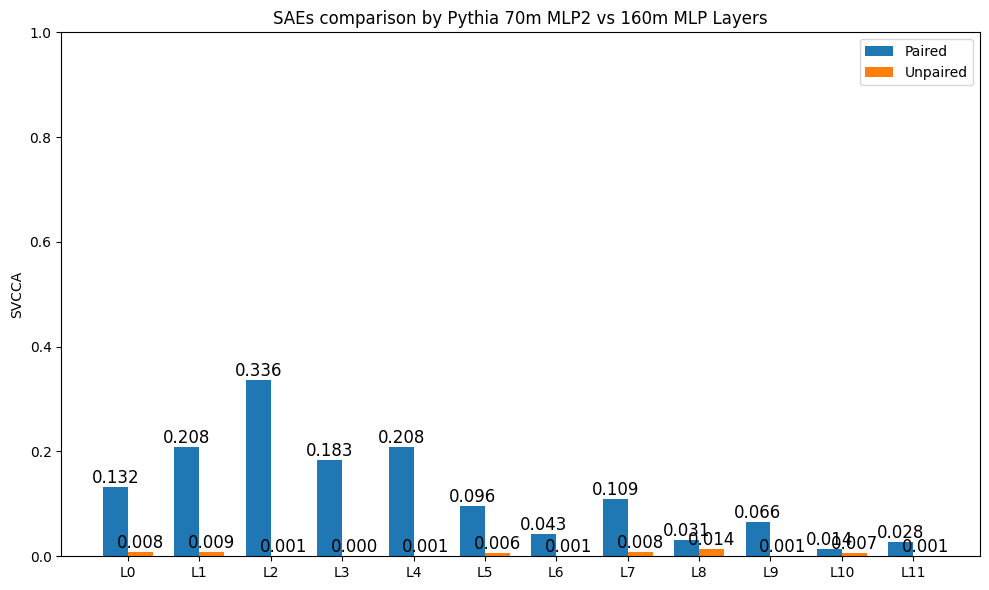

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

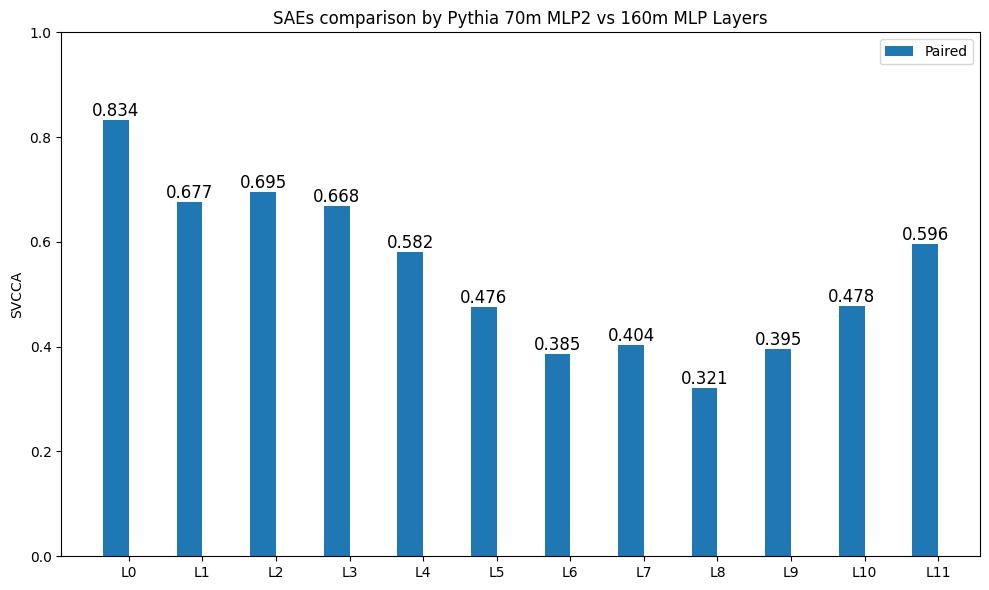

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

# case A, MLP5 vs

## load SAE model A

In [ ]:
layer_id = 5
hookpoint = "layers." + str(layer_id)
name = "EleutherAI/sae-pythia-70m-32k"
decoder=True

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 512}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_np = sae.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model(**inputs, output_hidden_states=True)
    reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## find how many cols of tensor are all 0

In [ ]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

# Count zero columns
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
print("Number of zero columns:", zero_cols_count), zero_cols_indices

Number of zero columns: 139


(None,
 array([   18,   354,   416,   748,   844,  1464,  1868,  1950,  2188,
         2463,  2659,  3315,  3436,  3523,  3762,  3857,  3951,  4014,
         4225,  4724,  4738,  4890,  5150,  5576,  5931,  5987,  6080,
         6592,  7111,  7325,  7925,  7949,  7975,  8195,  8467,  8498,
         8735,  8790,  9142,  9237,  9259,  9264, 10496, 10581, 10622,
        10686, 10975, 10993, 11283, 11556, 11611, 11652, 11677, 12147,
        12221, 12453, 12549, 12752, 13022, 13045, 13263, 13626, 13634,
        13696, 13981, 14286, 15164, 15525, 16529, 16890, 17165, 17483,
        17492, 17601, 17863, 18093, 18278, 18300, 18435, 18661, 19188,
        19499, 19515, 19612, 19711, 19756, 19809, 19883, 19902, 20439,
        20565, 20710, 20891, 21254, 21796, 22161, 22173, 22311, 23702,
        23843, 24128, 24154, 24260, 24330, 24339, 24455, 24470, 24793,
        24916, 25000, 25667, 25743, 26630, 26771, 26795, 26944, 27705,
        27902, 28215, 28328, 28572, 29085, 29269, 29508, 29616, 30477,

## L5 v L11: analyze corr

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

# for i in range(1, 3): # 0, 12
i=11
dictscores = {}

hookpoint = "layers." + str(i)

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae_2,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model_2(**inputs, output_hidden_states=True)
    reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_B.cpu().numpy())
print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

Number of zero columns: 427


In [ ]:
"""
`batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
"""
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.146697998046875


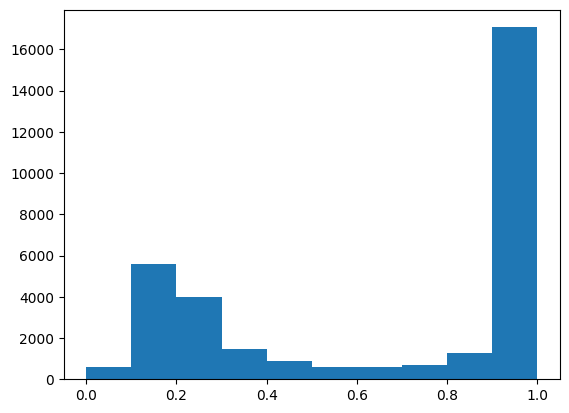

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  11852 | Count:  2903 | Corr:  0.0
FeatID:  15537 | Count:  2331 | Corr:  0.20937006
FeatID:  19570 | Count:  959 | Corr:  0.0
FeatID:  7780 | Count:  948 | Corr:  0.827714
FeatID:  289 | Count:  830 | Corr:  0.9822878
FeatID:  30538 | Count:  795 | Corr:  0.9596971
FeatID:  27700 | Count:  574 | Corr:  0.10660736
FeatID:  11085 | Count:  531 | Corr:  0.98619294
FeatID:  0 | Count:  427 | Corr:  0.9762802
FeatID:  9814 | Count:  424 | Corr:  0.98645586
FeatID:  20910 | Count:  410 | Corr:  0.96747476
FeatID:  20191 | Count:  408 | Corr:  0.9772139
FeatID:  1935 | Count:  401 | Corr:  0.79832655
FeatID:  27047 | Count:  303 | Corr:  0.40589902
FeatID:  18466 | Count:  286 | Corr:  0.5791689
FeatID:  15868 | Count:  259 | Corr:  0.97947073
FeatID:  2292 | Count:  252 | Corr:  0.40101227
FeatID:  19973 | Count:  240 | Corr:  0.8833375
FeatID:  21205 | Count:  231 | Corr:  0.9880814
FeatID:  622 | Count:  213 | Corr:  0.48931608


In [ ]:
# num_featB_to_rmv
sum([item[1] for item in sorted_feat_counts[:3]])

6193

In [ ]:
max_element = len(highest_correlations_indices_AB)
counts = Counter(highest_correlations_indices_AB)

# Initialize bins
bin_0 = 0
bin_1 = 0
bin_2_to_10 = 0
bin_11_to_100 = 0
bin_101_to_1000 = 0
bin_over_1000 = 0

# Calculate bins
for i in range(max_element + 1):
    count = counts.get(i, 0)
    if count == 0:
        bin_0 += 1
    elif count == 1:
        bin_1 += 1
    elif 2 <= count <= 10:
        bin_2_to_10 += 1
    elif 11 <= count <= 100:
        bin_11_to_100 += 1
    elif 101 <= count <= 1000:
        bin_101_to_1000 += 1
    elif count > 1000:
        bin_over_1000 += 1

# Display bin counts
print(f"Count of elements appearing 0 times: {bin_0}")
print(f"Count of elements appearing exactly 1 time: {bin_1}")
print(f"Count of elements appearing between 2 and 10 times: {bin_2_to_10}")
print(f"Count of elements appearing between 11 and 100 times: {bin_11_to_100}")
print(f"Count of elements appearing between 101 and 1000 times: {bin_101_to_1000}")
print(f"Count of elements appearing over 1000 times: {bin_over_1000}")

Count of elements appearing 0 times: 27962
Count of elements appearing exactly 1 time: 2399
Count of elements appearing between 2 and 10 times: 2111
Count of elements appearing between 11 and 100 times: 259
Count of elements appearing between 101 and 1000 times: 36
Count of elements appearing over 1000 times: 2


In [ ]:
# Filter out elements with counts over 100
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

In [ ]:
unkept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count > 100]
len(unkept_modA_feats)

38

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)

In [ ]:
len(filt_corr_ind_B)

16558

In [ ]:
len(filt_corr_ind_A)

16558

In [ ]:
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

% unique:  0.29031283971494143


In [ ]:
len(highest_correlations_values_AB[filt_corr_ind_B])

16558

In [ ]:
new_corrs = []
for fInd in filt_corr_ind_B:
    new_corrs.append(highest_correlations_values_AB[fInd])

In [ ]:
sum(new_corrs) / len(new_corrs)

0.42030803802177835

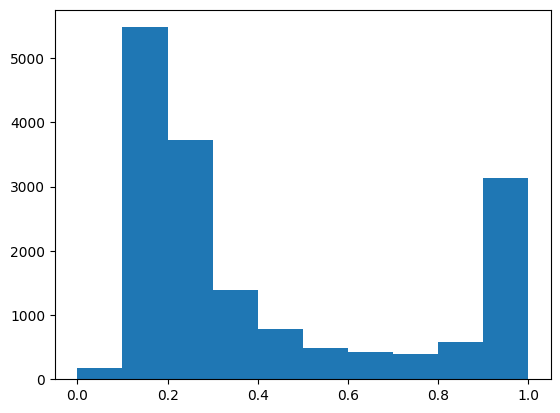

In [ ]:
plt.hist(new_corrs)
plt.show()

### run sim metric - filt counts over 100

In [ ]:
###########
# sim tests

dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")

num_feats = len(filt_corr_ind_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr: 0.661913313214427
svcca_paired: 0.10337234515800466
svcca_unpaired: 0.0006842780575661364




### run sim metric - filt counts over 1000

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 1000]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  0.17732118484636097
num feats after filt:  27109


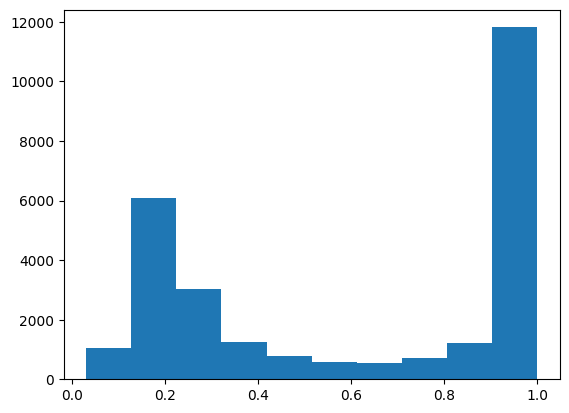

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_indices_A) / len(new_highest_correlations_indices_A)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr: 0.661913313214427
svcca_paired: 0.025289169357720968
svcca_unpaired: 0.0023867186395004165




### run sim metric - filt counts over 500

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 500]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  0.21385354568911824
num feats after filt:  22478


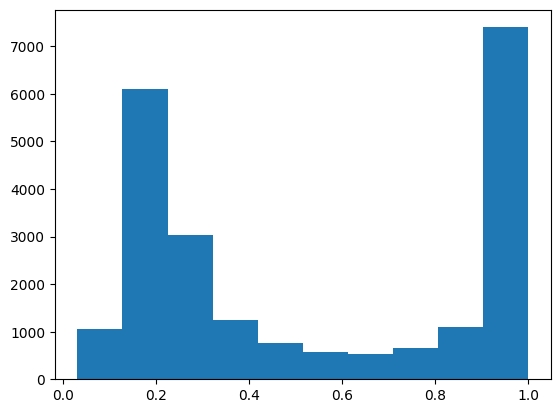

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr_filt: 0.5376803919889078
svcca_paired: 0.0695354979204272
svcca_unpaired: 0.0033291079079256877




### run sim metric - filt counts over 10

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 10]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  0.47275767112509837
num feats after filt:  10168


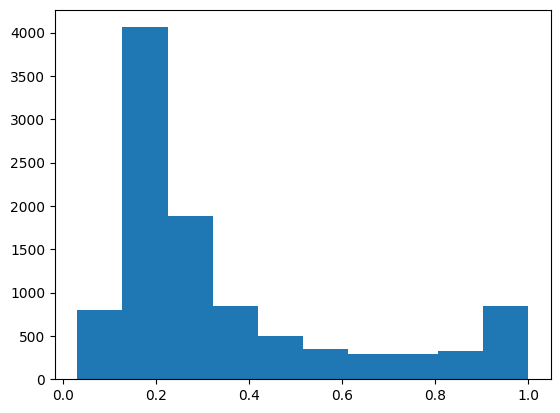

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr_filt: 0.34629352490712956
svcca_paired: 0.1731530045043145
svcca_unpaired: 0.006641640865852874




In [ ]:
new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

% unique after filt:  0.47974051896207587
num feats after filt:  10020
mean_actv_corr_filt: 0.35015024227757535
svcca_paired: 0.17592548676842593
svcca_unpaired: 0.006775685430383321




### run sim metric - filt counts over 1

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 1]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  1.000208073241781
num feats after filt:  4806


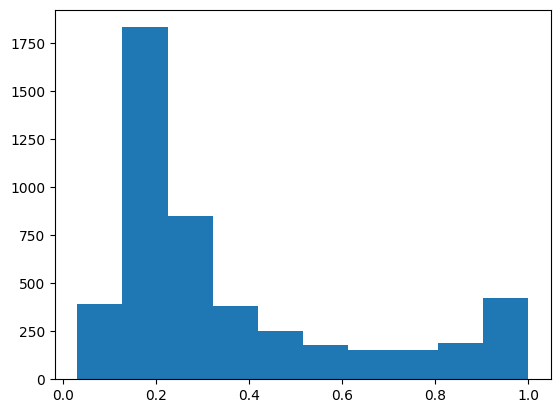

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr_filt: 0.35924809314372563
svcca_paired: 0.21892348295264322
svcca_unpaired: 0.0038717700663924775




In [ ]:
new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

% unique after filt:  1.0173544973544975
num feats after filt:  4725
mean_actv_corr_filt: 0.36397743411953487
svcca_paired: 0.22213857369837672
svcca_unpaired: 0.0014507777585459779




## loop- filt counts over 100 and rmv corr of 0

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

for i in range(0, 12): # 0, 12
    dictscores = {}

    hookpoint = "layers." + str(i)

    repo_path = Path(
                snapshot_download(
                    name,
                    allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                    # allow_patterns = None
                )
            )
    if hookpoint is not None:
        repo_path = repo_path / hookpoint
    path = Path(repo_path)
    cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
    d_in = cfg_dict.pop("d_in")
    cfg = SaeConfig(**cfg_dict)

    sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

    load_model(
        model=sae_2,
        filename=str(path / "sae.safetensors"),
        device=str(device),
        strict=decoder,
    )

    weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        outputs = model_2(**inputs, output_hidden_states=True)
        reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
    reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

    """
    `batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
    """
    highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
    highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
    highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

    num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
    print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

    dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

    ###########
    # filter

    sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
    kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

    filt_corr_ind_A = []
    filt_corr_ind_B = []
    seen = set()
    for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
        if ind_A in kept_modA_feats:
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
        elif ind_A not in seen:  # only keep one if it's over count X
            seen.add(ind_A)
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
    # num_unq_pairs = len(list(set(filt_corr_ind_A)))
    # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

    new_highest_correlations_indices_A = []
    new_highest_correlations_indices_B = []
    new_highest_correlations_values = []

    for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
        val = highest_correlations_values_AB[ind_B]
        if val > 0:
            new_highest_correlations_indices_A.append(ind_A)
            new_highest_correlations_indices_B.append(ind_B)
            new_highest_correlations_values.append(val)

    print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
    print("num feats after filt: ", len(new_highest_correlations_indices_A))

    dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

    ###########
    # sim tests

    # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
    dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

    # num_feats = len(filt_corr_ind_A)
    num_feats = len(new_highest_correlations_indices_A)
    dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

    print("Layer: " + str(i))
    for key, value in dictscores.items():
        print(key + ": " + str(value))
    print("\n")

    layer_to_dictscores[i] = dictscores

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.13580322265625
% unique after filt:  0.1904721140264521
num feats after filt:  23363
Layer: 0
mean_actv_corr: 0.6399477781030782
svcca_paired: 0.03353353655839476
svcca_unpaired: 0.004143857941091937




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.16845703125
% unique after filt:  0.18090649886933438
num feats after filt:  30513
Layer: 1
mean_actv_corr: 0.3195505480326801
svcca_paired: 0.030901813915503
svcca_unpaired: 0.0008553229367165998




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.175933837890625
% unique after filt:  0.186847734491476
num feats after filt:  30854
Layer: 2
mean_actv_corr: 0.29479954633961825
svcca_paired: 0.07996014755127008
svcca_unpaired: 0.004516053178549648




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.212921142578125
% unique after filt:  0.21710853871048047
num feats after filt:  32136
Layer: 3
mean_actv_corr: 0.3328287333724802
svcca_paired: 0.038265567271303313
svcca_unpaired: 0.005887248260409291




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.217254638671875
% unique after filt:  0.22284480060101422
num feats after filt:  31946
Layer: 4
mean_actv_corr: 0.329717890045913
svcca_paired: 0.01580747429916916
svcca_unpaired: 0.00076761518228538




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.173370361328125
% unique after filt:  0.3606297213229226
num feats after filt:  15753
Layer: 5
mean_actv_corr: 0.6621008103410304
svcca_paired: 0.10078533271336211
svcca_unpaired: 0.004342583552631695




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.170196533203125
% unique after filt:  0.26936823802163834
num feats after filt:  20704
Layer: 6
mean_actv_corr: 0.6003557477700951
svcca_paired: 0.1265594236066815
svcca_unpaired: 0.0010586424535850856




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.182098388671875
% unique after filt:  0.25164473684210525
num feats after filt:  23712
Layer: 7
mean_actv_corr: 0.5562490744024444
svcca_paired: 0.09247844040461099
svcca_unpaired: 0.020399636293733543




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.14825439453125
% unique after filt:  0.23879276445143532
num feats after filt:  20344
Layer: 8
mean_actv_corr: 0.5200536348048672
svcca_paired: 0.12157543582613076
svcca_unpaired: 0.006130131809514369




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.109771728515625
% unique after filt:  0.27466401954795355
num feats after filt:  13096
Layer: 9
mean_actv_corr: 0.7180895000348073
svcca_paired: 0.12365984971282348
svcca_unpaired: 0.010443924028110944




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.071990966796875
% unique after filt:  0.2566920565832427
num feats after filt:  9190
Layer: 10
mean_actv_corr: 0.8752770388724684
svcca_paired: 0.04029153380730151
svcca_unpaired: 0.008846695883879164




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.146697998046875
% unique after filt:  0.29033037385999877
num feats after filt:  16557
Layer: 11
mean_actv_corr: 0.661913313214427
svcca_paired: 0.1033591179251681
svcca_unpaired: 0.0047202913768851




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.6399,
  'svcca_paired': 0.0335,
  'svcca_unpaired': 0.0041},
 1: {'mean_actv_corr': 0.3196,
  'svcca_paired': 0.0309,
  'svcca_unpaired': 0.0009},
 2: {'mean_actv_corr': 0.2948, 'svcca_paired': 0.08, 'svcca_unpaired': 0.0045},
 3: {'mean_actv_corr': 0.3328,
  'svcca_paired': 0.0383,
  'svcca_unpaired': 0.0059},
 4: {'mean_actv_corr': 0.3297,
  'svcca_paired': 0.0158,
  'svcca_unpaired': 0.0008},
 5: {'mean_actv_corr': 0.6621,
  'svcca_paired': 0.1008,
  'svcca_unpaired': 0.0043},
 6: {'mean_actv_corr': 0.6004,
  'svcca_paired': 0.1266,
  'svcca_unpaired': 0.0011},
 7: {'mean_actv_corr': 0.5562,
  'svcca_paired': 0.0925,
  'svcca_unpaired': 0.0204},
 8: {'mean_actv_corr': 0.5201,
  'svcca_paired': 0.1216,
  'svcca_unpaired': 0.0061},
 9: {'mean_actv_corr': 0.7181,
  'svcca_paired': 0.1237,
  'svcca_unpaired': 0.0104},
 10: {'mean_actv_corr': 0.8753,
  'svcca_paired': 0.0403,
  'svcca_unpaired': 0.0088},
 11: {'mean_actv_corr': 0.6619,
  'svcca_paired': 0.1034,
 

## plot

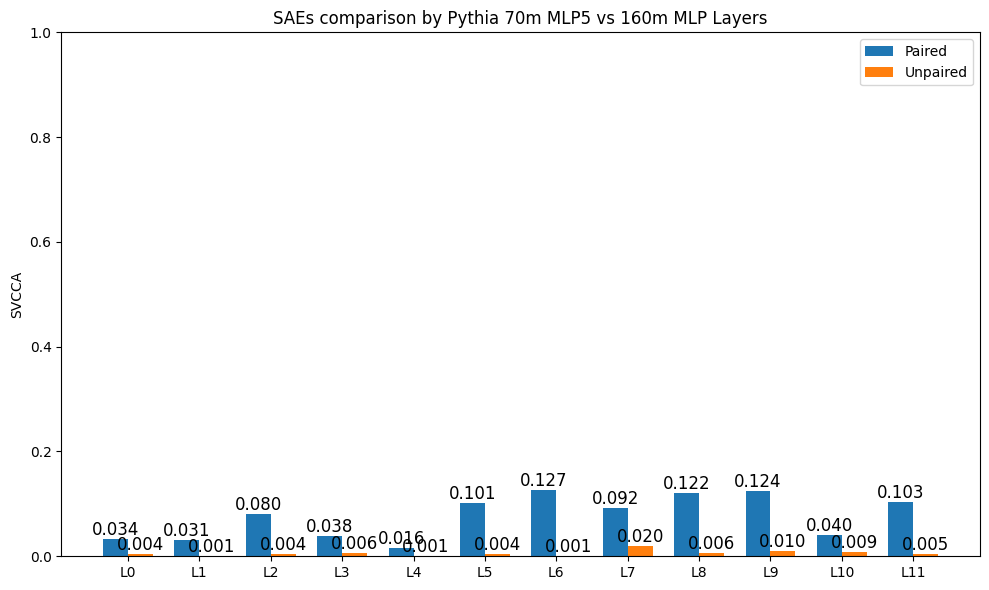

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

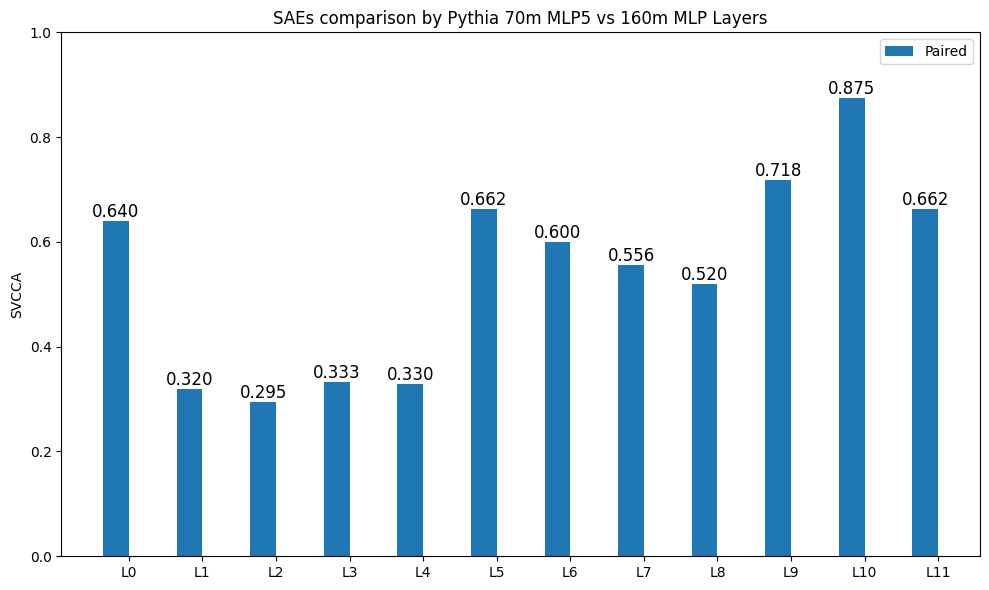

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

# case A, MLP0 vs

## load SAE model A

In [ ]:
layer_id = 0
hookpoint = "layers." + str(layer_id)
name = "EleutherAI/sae-pythia-70m-32k"
decoder=True

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 512}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_np = sae.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model(**inputs, output_hidden_states=True)
    reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

## find how many cols of tensor are all 0

In [ ]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

# Count zero columns
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
print("Number of zero columns:", zero_cols_count), zero_cols_indices

Number of zero columns: 32708


(None, array([    0,     1,     2, ..., 32765, 32766, 32767]))

## analyze corr

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

# for i in range(1, 3): # 0, 12
i=0
dictscores = {}

hookpoint = "layers." + str(i)

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae_2,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model_2(**inputs, output_hidden_states=True)
    reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_B.cpu().numpy())
print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

Number of zero columns: 32701


In [ ]:
"""
`batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
"""
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.00091552734375


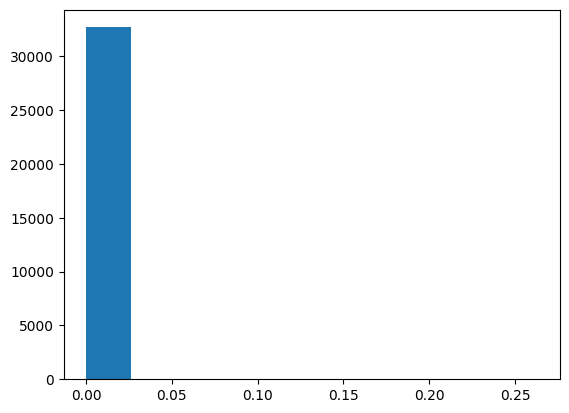

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  0 | Count:  32701 | Corr:  0.0
FeatID:  31620 | Count:  6 | Corr:  0.0
FeatID:  32618 | Count:  6 | Corr:  0.0
FeatID:  16266 | Count:  5 | Corr:  0.0
FeatID:  17279 | Count:  5 | Corr:  0.0
FeatID:  30880 | Count:  5 | Corr:  0.0
FeatID:  3658 | Count:  5 | Corr:  0.0
FeatID:  4734 | Count:  3 | Corr:  0.0
FeatID:  30225 | Count:  2 | Corr:  0.0
FeatID:  6450 | Count:  2 | Corr:  0.0
FeatID:  23454 | Count:  2 | Corr:  0.0
FeatID:  15116 | Count:  2 | Corr:  0.0
FeatID:  5836 | Count:  2 | Corr:  0.0
FeatID:  9508 | Count:  2 | Corr:  0.0
FeatID:  1135 | Count:  2 | Corr:  0.0
FeatID:  9502 | Count:  2 | Corr:  0.0
FeatID:  6770 | Count:  2 | Corr:  0.0
FeatID:  15528 | Count:  2 | Corr:  0.0
FeatID:  296 | Count:  1 | Corr:  0.0
FeatID:  16260 | Count:  1 | Corr:  0.0


In [ ]:
# num_featB_to_rmv
sum([item[1] for item in sorted_feat_counts[:3]])

32713

In [ ]:
max_element = len(highest_correlations_indices_AB)
counts = Counter(highest_correlations_indices_AB)

# Initialize bins
bin_0 = 0
bin_1 = 0
bin_2_to_10 = 0
bin_11_to_100 = 0
bin_101_to_1000 = 0
bin_over_1000 = 0

# Calculate bins
for i in range(max_element + 1):
    count = counts.get(i, 0)
    if count == 0:
        bin_0 += 1
    elif count == 1:
        bin_1 += 1
    elif 2 <= count <= 10:
        bin_2_to_10 += 1
    elif 11 <= count <= 100:
        bin_11_to_100 += 1
    elif 101 <= count <= 1000:
        bin_101_to_1000 += 1
    elif count > 1000:
        bin_over_1000 += 1

# Display bin counts
print(f"Count of elements appearing 0 times: {bin_0}")
print(f"Count of elements appearing exactly 1 time: {bin_1}")
print(f"Count of elements appearing between 2 and 10 times: {bin_2_to_10}")
print(f"Count of elements appearing between 11 and 100 times: {bin_11_to_100}")
print(f"Count of elements appearing between 101 and 1000 times: {bin_101_to_1000}")
print(f"Count of elements appearing over 1000 times: {bin_over_1000}")

Count of elements appearing 0 times: 32739
Count of elements appearing exactly 1 time: 12
Count of elements appearing between 2 and 10 times: 17
Count of elements appearing between 11 and 100 times: 0
Count of elements appearing between 101 and 1000 times: 0
Count of elements appearing over 1000 times: 1


In [ ]:
# Filter out elements with counts over 100
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

In [ ]:
unkept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count > 100]
len(unkept_modA_feats)

1

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)

In [ ]:
len(filt_corr_ind_B)

68

In [ ]:
len(filt_corr_ind_A)

68

In [ ]:
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

% unique:  0.4411764705882353


In [ ]:
len(highest_correlations_values_AB[filt_corr_ind_B])

68

In [ ]:
new_corrs = []
for fInd in filt_corr_ind_B:
    new_corrs.append(highest_correlations_values_AB[fInd])

In [ ]:
sum(new_corrs) / len(new_corrs)

0.10280367556740255

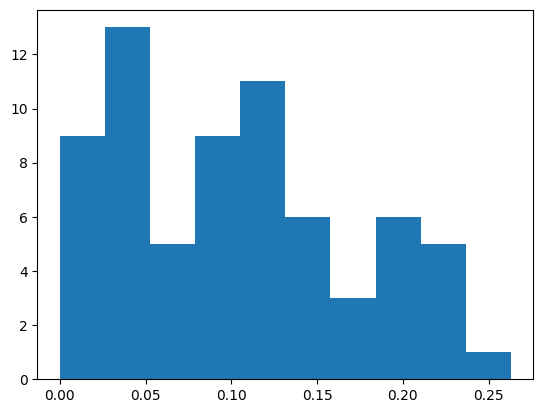

In [ ]:
plt.hist(new_corrs)
plt.show()

### run sim metric - filt counts over 100

In [ ]:
###########
# sim tests

dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")

num_feats = len(filt_corr_ind_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr: 0.00021333770564524457
svcca_paired: 0.017743129514827073
svcca_unpaired: 0.07701305767870345




### run sim metric - filt counts over 1000

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 1000]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  0.44776119402985076
num feats after filt:  67


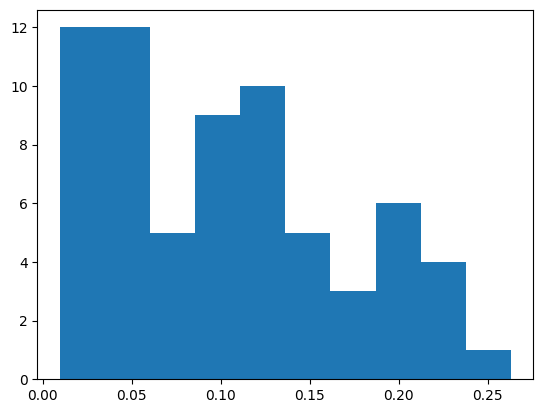

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_indices_A) / len(new_highest_correlations_indices_A)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr: 0.00021333770564524457
svcca_paired: 0.017574070380918762
svcca_unpaired: 0.1417799601771894
mean_actv_corr_filt: 17845.4776119403




### run sim metric - filt counts over 500

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 500]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after filt: ", len(new_highest_correlations_indices_A))

% unique after filt:  0.44776119402985076
num feats after filt:  67


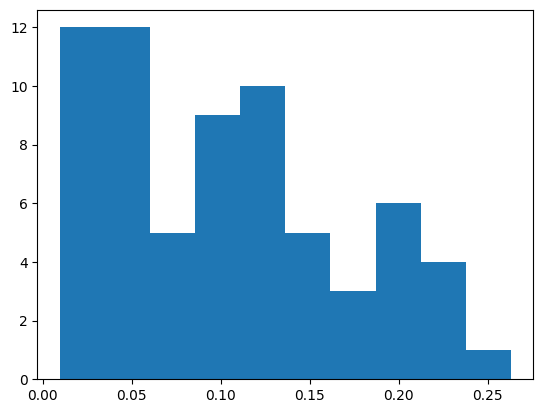

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
###########
# sim tests
dictscores = {}
dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

num_feats = len(new_highest_correlations_indices_A)
dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

# print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

# layer_to_dictscores[i] = dictscores

mean_actv_corr_filt: 0.10433805878482648
svcca_paired: 0.017574070380918762
svcca_unpaired: 0.11109173471482175




## loop- filt counts over 100 and rmv corr of 0

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

for i in range(0, 12): # 0, 12
    dictscores = {}

    hookpoint = "layers." + str(i)

    repo_path = Path(
                snapshot_download(
                    name,
                    allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                    # allow_patterns = None
                )
            )
    if hookpoint is not None:
        repo_path = repo_path / hookpoint
    path = Path(repo_path)
    cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
    d_in = cfg_dict.pop("d_in")
    cfg = SaeConfig(**cfg_dict)

    sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

    load_model(
        model=sae_2,
        filename=str(path / "sae.safetensors"),
        device=str(device),
        strict=decoder,
    )

    weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        outputs = model_2(**inputs, output_hidden_states=True)
        reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
    reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

    """
    `batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
    """
    highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
    highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
    highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

    num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
    print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

    dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

    ###########
    # filter

    sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
    kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

    filt_corr_ind_A = []
    filt_corr_ind_B = []
    seen = set()
    for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
        if ind_A in kept_modA_feats:
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
        elif ind_A not in seen:  # only keep one if it's over count X
            seen.add(ind_A)
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
    # num_unq_pairs = len(list(set(filt_corr_ind_A)))
    # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))

    new_highest_correlations_indices_A = []
    new_highest_correlations_indices_B = []
    new_highest_correlations_values = []

    for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
        val = highest_correlations_values_AB[ind_B]
        if val > 0:
            new_highest_correlations_indices_A.append(ind_A)
            new_highest_correlations_indices_B.append(ind_B)
            new_highest_correlations_values.append(val)

    print("% unique after filt: ", num_unq_pairs / len(new_highest_correlations_indices_A))
    print("num feats after filt: ", len(new_highest_correlations_indices_A))

    dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

    ###########
    # sim tests

    # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
    dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

    # num_feats = len(filt_corr_ind_A)
    num_feats = len(new_highest_correlations_indices_A)
    dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

    print("Layer: " + str(i))
    for key, value in dictscores.items():
        print(key + ": " + str(value))
    print("\n")

    layer_to_dictscores[i] = dictscores

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.00091552734375
% unique after filt:  0.44776119402985076
num feats after filt:  67
Layer: 0
mean_actv_corr: 0.00021333770564524457
mean_actv_corr_filt: 0.10433805878482648
svcca_paired: 0.017574070380918762
svcca_unpaired: 0.23807243130201158




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.0006103515625
% unique after filt:  0.43478260869565216
num feats after filt:  46
Layer: 1
mean_actv_corr: 0.0001674961989692747
mean_actv_corr_filt: 0.11931555321359116
svcca_paired: 0.1603657374314235
svcca_unpaired: 0.12286800220514207




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.001678466796875
% unique after filt:  0.12249443207126949
num feats after filt:  449
Layer: 2
mean_actv_corr: 0.001449773212840455
mean_actv_corr_filt: 0.10580438449522502
svcca_paired: 0.036551930475917066
svcca_unpaired: 0.03286782416477466




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.001861572265625
% unique after filt:  0.04354032833690221
num feats after filt:  1401
Layer: 3
mean_actv_corr: 0.02186414314522267
mean_actv_corr_filt: 0.0779434217816135
svcca_paired: 0.1062667202941982
svcca_unpaired: 0.019781726138479897




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.001861572265625
% unique after filt:  0.059628543499511244
num feats after filt:  1023
Layer: 4
mean_actv_corr: 0.06770031622978934
mean_actv_corr_filt: 0.08857712321090835
svcca_paired: 0.07687420913294327
svcca_unpaired: 0.014980968550341167




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.001861572265625
% unique after filt:  0.049273021001615507
num feats after filt:  1238
Layer: 5
mean_actv_corr: 0.06313314641215584
mean_actv_corr_filt: 0.08716757374444016
svcca_paired: 0.015220018662427216
svcca_unpaired: 0.025808456902550413




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.001861572265625
% unique after filt:  0.07830551989730423
num feats after filt:  779
Layer: 6
mean_actv_corr: 0.11639955167910898
mean_actv_corr_filt: 0.09083653849326026
svcca_paired: 0.10000599506057492
svcca_unpaired: 0.00387743098098781




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
layer_to_dictscores

## plot

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)